In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind

In [3]:
ab_data = pd.read_csv('../data/ab_data.csv')

In [4]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [5]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [6]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [7]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [8]:
daily_data['conversion'] = daily_data['converted']/daily_data['users_count'] * 100
print(round(daily_data[
    (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
]['conversion'], 2))
print(daily_data.head())

6    12.32
Name: conversion, dtype: float64
   timestamp group  users_count  converted  conversion
0 2017-01-02     A         2851        357   12.521922
1 2017-01-02     B         2848        339   11.903090
2 2017-01-03     A         6584        749   11.376063
3 2017-01-03     B         6620        754   11.389728
4 2017-01-04     A         6573        797   12.125361


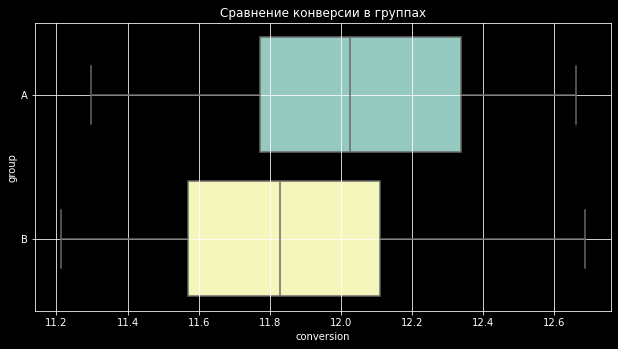

In [9]:
fig = plt.figure(figsize=(8, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
ax.set_title('Сравнение конверсии в группах')
ax.grid();

In [10]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
conversion_piv

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


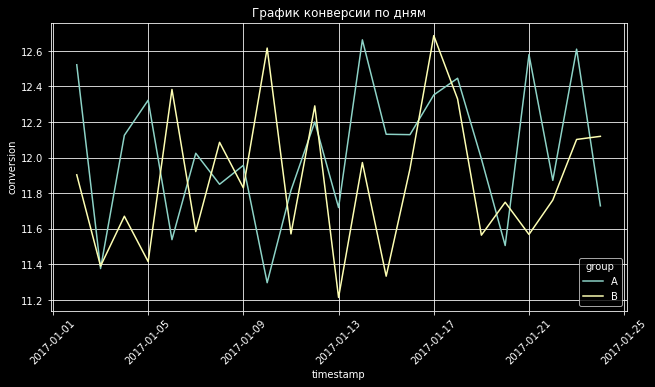

In [11]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1]) # добавляем систему координат
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45) # задаём поворот меток на оси абсцисс
ax.grid();

In [12]:
daily_data_a = daily_data[daily_data['group'] == 'A'] # выделяем данные группы А
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum() # считаем кумулятивное количество посетителей
daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head() # выводим время, количество посетителей и кумулятивное количество посетителей

/home/ivan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/ivan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [13]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum() # вычисляем кумулятивную сумму количества посетителей
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum() # вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100 # вычисляем кумулятивную конверсию
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


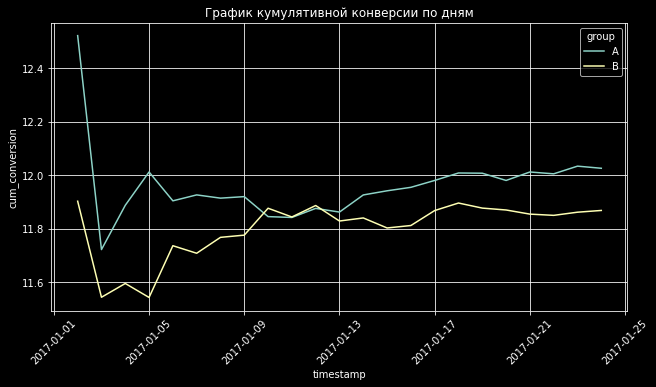

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

In [15]:
sample_a = pd.read_csv('../data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('../data/ab_test-redesign_sample_b.csv')

In [16]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

In [17]:
sample_a_g = sample_a.groupby('date').agg({
    'cid':'count',
    'transactions': 'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

sample_b_g = sample_b.groupby('date').agg({
    'cid':'count',
    'transactions': 'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

In [18]:
sample_a_g[sample_a_g["date"] == "2020-11-08"]

,date,users_count,transactions,revenue
2,2020-11-08,3354,25,846051


In [19]:
sample_a_g["users_count_cum"] = sample_a_g["users_count"].cumsum()
sample_a_g["transactions_cum"] = sample_a_g["transactions"].cumsum()
sample_a_g["revenue_cum"] = sample_a_g["revenue"].cumsum()
sample_a_g["conversion"] = sample_a_g["transactions"] / sample_a_g["users_count_cum"] * 100
sample_a_g["conversion_cum"] = sample_a_g["transactions_cum"] / sample_a_g["users_count_cum"] *100
sample_a_g["mean_revenue_cum"] = sample_a_g["revenue_cum"] / sample_a_g["transactions_cum"]

In [20]:
sample_b_g["users_count_cum"] = sample_b_g["users_count"].cumsum()
sample_b_g["transactions_cum"] = sample_b_g["transactions"].cumsum()
sample_b_g["revenue_cum"] = sample_b_g["revenue"].cumsum()
sample_b_g["conversion"] = sample_b_g["transactions"] / sample_b_g["users_count_cum"] * 100
sample_b_g["conversion_cum"] = sample_b_g["transactions_cum"] / sample_b_g["users_count_cum"] *100
sample_b_g["mean_revenue_cum"] = sample_b_g["revenue_cum"] / sample_b_g["transactions_cum"]

In [21]:
print(sample_a_g["conversion_cum"].mean())
print(sample_b_g["conversion_cum"].mean())

0.7127554606160046
0.7621783890588012


In [22]:
sample_a_g['group'] = "A"
sample_b_g['group'] = "B"

In [23]:
common_sample = pd.concat([sample_a_g, sample_b_g])

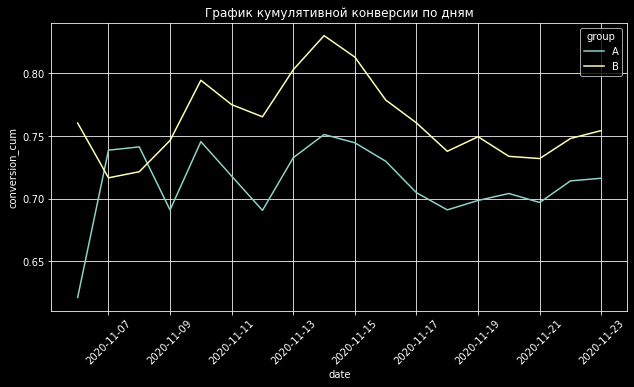

In [24]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='conversion_cum', data=common_sample, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

In [25]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


In [26]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


In [27]:
time_data = pd.read_excel('../data/time_data.xlsx')
time_data.head()

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


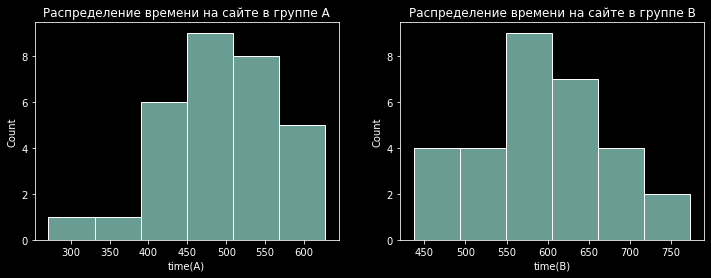

In [28]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [30]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [32]:
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B
